In [31]:
import pandas as pd
import numpy as np
import deeptime as dt
import matplotlib.pyplot as plt
import hexagonal_grid
from tqdm import tqdm



In [15]:
d=pd.read_table("SOM.neuron.classification.dat.xz")
d["RFrame"]=d.groupby(['Replica']).cumcount()
d["State"]=d["Neuron.classif"]-1

In [13]:
dg=d.groupby("Replica")
traj_list=[dg.get_group(x).State.to_numpy() for x in dg.groups]

100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


Text(0, 0.5, 'timescale (steps)')

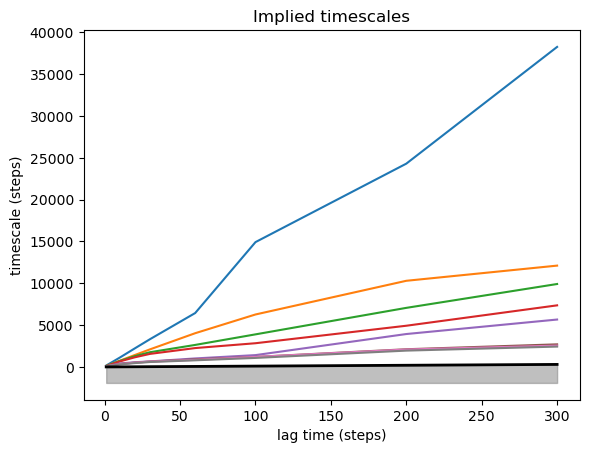

In [38]:
models = []
lagtimes = [1,10,20,30,60,100,200,300]
for lagtime in tqdm(lagtimes):
    counts = dt.markov.TransitionCountEstimator(lagtime=lagtime, count_mode='sliding').fit_fetch(traj_list)
    #mod=dt.markov.msm.BayesianMSM(n_samples=50).fit(counts,ignore_counting_mode=True).fetch()
    mod=dt.markov.msm.MaximumLikelihoodMSM().fit_fetch(counts)
    models.append(mod)
    #models.append()


Text(0, 0.5, 'timescale (steps)')

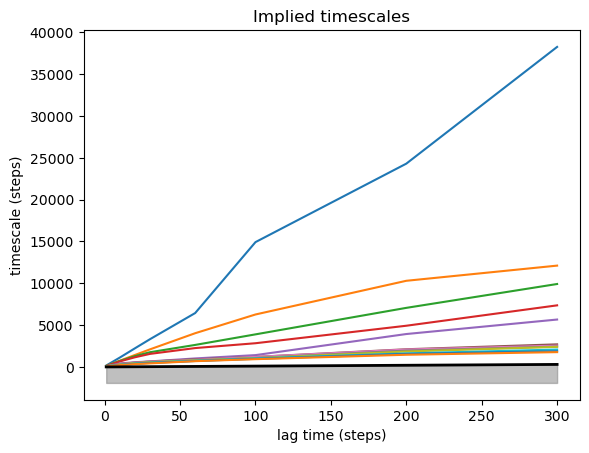

In [40]:
its_data = dt.util.validation.implied_timescales(models)

fig, ax = plt.subplots(1, 1)
dt.plots.plot_implied_timescales(its_data, n_its=12, ax=ax)
#ax.set_yscale('log')
ax.set_title('Implied timescales')
ax.set_xlabel('lag time (steps)')
ax.set_ylabel('timescale (steps)')



In [41]:
pccamodel = models[2]
pcca = pccamodel.pcca(n_metastable_sets=6)


In [43]:
pcca.memberships

array([[2.06704282e-03, 2.48261768e-03, 8.64407950e-02, 3.62399116e-02,
        6.22065092e-02, 8.10563124e-01],
       [9.72013194e-04, 1.29441167e-03, 1.10559789e-01, 2.15231915e-02,
        5.80628815e-02, 8.07587713e-01],
       [1.29518004e-03, 1.51240079e-03, 9.14870251e-02, 1.83480623e-02,
        9.33639019e-02, 7.93993430e-01],
       ...,
       [7.54347644e-04, 1.83402826e-03, 1.44359814e-01, 1.35546312e-01,
        3.10459535e-02, 6.86459544e-01],
       [1.16023977e-03, 2.74988110e-03, 8.98571207e-02, 2.15470912e-01,
        2.60853627e-02, 6.64676484e-01],
       [2.38155653e-06, 5.37982219e-03, 3.08716685e-03, 9.76082565e-01,
        1.49983982e-02, 4.49666695e-04]])

In [45]:
hgrid = hexagonal_grid.hexagonal_grid(20,20)

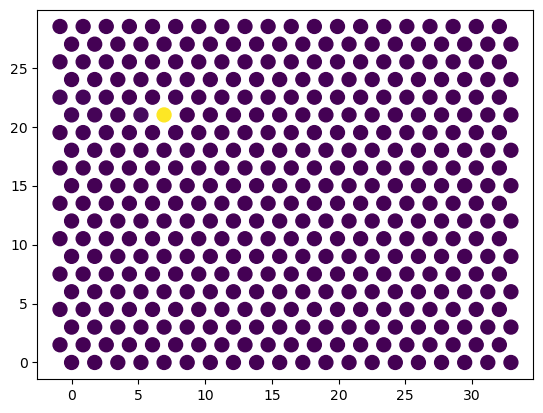

In [53]:
plt.scatter(hgrid[:,0],hgrid[:,1],s=100,c=pcca.memberships[:,0])

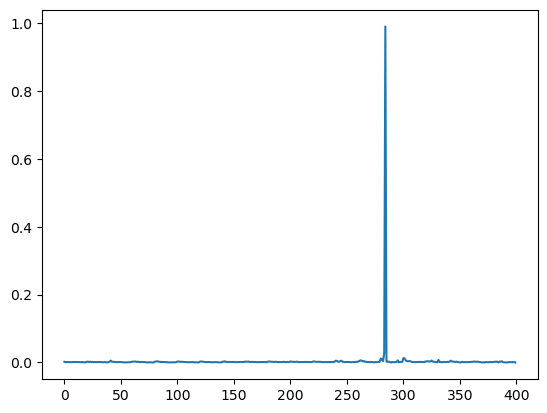

In [56]:
plt.plot(pcca.memberships[:,0])

In [57]:
np.where(pcca.memberships[:,0]>.5)

(array([284]),)

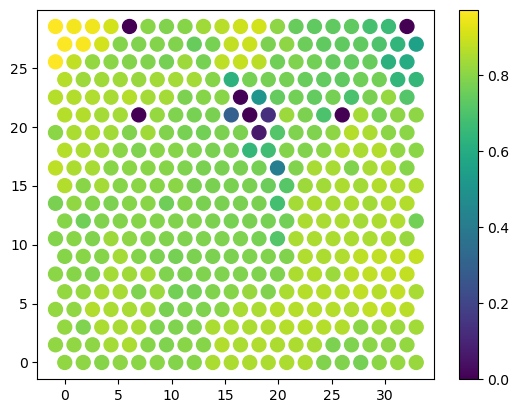

In [64]:
plt.scatter(hgrid[:,0],hgrid[:,1],s=100,c=pcca.memberships[:,5])
plt.colorbar()

In [65]:
pcca.coarse_grained_stationary_probability

array([0.00444659, 0.0053788 , 0.07972839, 0.03222602, 0.13964799,
       0.73857221])

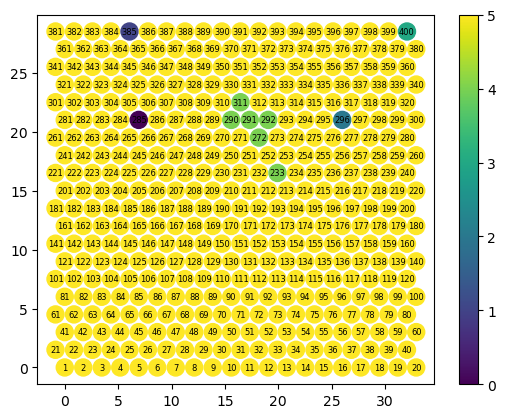

In [76]:
hexagonal_grid.state_plot(hgrid, pcca.assignments)
plt.colorbar()